<a href="https://colab.research.google.com/github/jseobyun/Samsung/blob/master/tutorial_cifar(solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#**What about data?** 
You can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

For images, packages such as Pillow, OpenCV are useful. Specifically for vision, we have created a package called torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are 3-channel color images of 32x32 pixels in size.

# **Training an image classifier**

We will do the following steps in order:

1. Dataset preparation
3. Define a Convolution Neural Network
4. Define a loss function 
5. Train the network on the training data
6. Test the network on the test data

**Dataset preparation** 

Using torchvision, it’s extremely easy to load CIFAR10.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Cuda is available :", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Cuda is available : True


  cat   dog   dog  frog


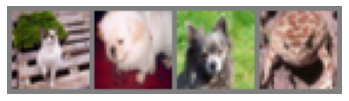

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Define a Convolution Neural Network**

Design your own CNN. input image has (3,32,32) dimension. Your network should encode the input image to (1, 10) output. 

In early stage of your network, start with convolution layers. Then put final fully connected layer that convert the output of last convolution layer to (1,10). 

You can use nn.Conv2D(), nn.MaxPool2d(), nn.Linear(), F.relu() and so on. When you change the shape of the feature, '.view()' will be usefull.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##### your code here #####
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        ##########################
        

    def forward(self, x):
        ##### your code here #####
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ##########################
        return x

net = Net()

**Define a loss function and optimizer**

Let's use a Classification nn.CrossEntropyLoss() and optim.SGD with momentum 0.9 and learning rate 0.001.

In [ ]:
import torch.optim as optim

##### your code here #####
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
##########################

**Train the network**

We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        # get the loss and do backward, optimization
        # Hint: .backward() , .step()
        ##### your code here #####
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()              
        ##########################
        

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.219
[1,  4000] loss: 1.869
[1,  6000] loss: 1.666
[1,  8000] loss: 1.587
[1, 10000] loss: 1.513
[1, 12000] loss: 1.467
[2,  2000] loss: 1.392
[2,  4000] loss: 1.378
[2,  6000] loss: 1.343
[2,  8000] loss: 1.334
[2, 10000] loss: 1.306
[2, 12000] loss: 1.313
Finished Training


**Test the network**

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

GroundTruth:    cat  ship  ship plane


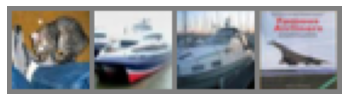

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are

The outputs are probabilities for the 10 classes. Higher the probability for a class, the more the network thinks that the image is of the particular class. 

So, let's get the index of the highest probability

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat plane   car  ship


Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 64 %
Accuracy of  bird : 38 %
Accuracy of   cat : 54 %
Accuracy of  deer : 49 %
Accuracy of   dog : 16 %
Accuracy of  frog : 78 %
Accuracy of horse : 46 %
Accuracy of  ship : 60 %
Accuracy of truck : 69 %
